In [1]:
# processing
#import d6tflow, luigi, d6tpipe
import pandas as pd
import numpy as np
import pathlib

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import cross_validate
import lightgbm
#lightgbm.LGBMRegressor
import shap
#shap.initjs()

# project
# import cfg, tasks
# import importlib # optional
# importlib.reload(cfg)
# importlib.reload(tasks)
# importlib.reload(visualize)

# Data Overview

In [2]:
# read original data
df = pd.read_csv('train.csv')
store = pd.read_csv('store.csv')
df = df.merge(store,how='left')
df.shape

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


(1017209, 18)

In [3]:
df.to_csv('rossmann.csv')

In [4]:
df.tail(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [4]:
print(df.columns)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [5]:
df = df.drop(columns=['PromoInterval'])
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN


In [6]:
from sklearn.metrics import mean_squared_error
mean = df['Sales'].mean()
df['Sales_mean'] = mean
mean_squared_error(df['Sales'], df['Sales_mean'])

14821916.983581567

In [7]:
print('observations and type')
df.info()

observations and type
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null object
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear         

In [8]:
print('missing values')
df.apply(lambda x:x.isna().sum()/len(x))

missing values


Store                        0.000000
DayOfWeek                    0.000000
Date                         0.000000
Sales                        0.000000
Customers                    0.000000
Open                         0.000000
Promo                        0.000000
StateHoliday                 0.000000
SchoolHoliday                0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002597
CompetitionOpenSinceMonth    0.317878
CompetitionOpenSinceYear     0.317878
Promo2                       0.000000
Promo2SinceWeek              0.499436
Promo2SinceYear              0.499436
Sales_mean                   0.000000
dtype: float64

In [9]:
print('unique values')
df.apply(lambda x: len(x.unique()))

unique values


Store                         1115
DayOfWeek                        7
Date                           942
Sales                        21734
Customers                     4086
Open                             2
Promo                            2
StateHoliday                     5
SchoolHoliday                    2
StoreType                        4
Assortment                       3
CompetitionDistance            655
CompetitionOpenSinceMonth       13
CompetitionOpenSinceYear        24
Promo2                           2
Promo2SinceWeek                 25
Promo2SinceYear                  8
Sales_mean                       1
dtype: int64

In [10]:
df.describe().round(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales_mean
count,1017209.00,1017209.0,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1014567.00,693861.00,693861.00,1017209.0,509178.00,509178.00,1017209.00
mean,558.43,4.0,5773.82,633.15,0.83,0.38,0.18,5430.09,7.22,2008.69,0.5,23.27,2011.75,5773.82
std,321.91,2.0,3849.93,464.41,0.38,0.49,0.38,7715.32,3.21,5.99,0.5,14.10,1.66,0.00
min,1.00,1.0,0.00,0.00,0.00,0.00,0.00,20.00,1.00,1900.00,0.0,1.00,2009.00,5773.82
25%,280.00,2.0,3727.00,405.00,1.00,0.00,0.00,710.00,4.00,2006.00,0.0,13.00,2011.00,5773.82
50%,558.00,4.0,5744.00,609.00,1.00,0.00,0.00,2330.00,8.00,2010.00,1.0,22.00,2012.00,5773.82
75%,838.00,6.0,7856.00,837.00,1.00,1.00,0.00,6890.00,10.00,2013.00,1.0,37.00,2013.00,5773.82
max,1115.00,7.0,41551.00,7388.00,1.00,1.00,1.00,75860.00,12.00,2015.00,1.0,50.00,2015.00,5773.82


In [11]:
df['Promo2'].unique()

array([0, 1])

# Distribution of Target Variable

Text(0.5, 1.0, 'Sales')

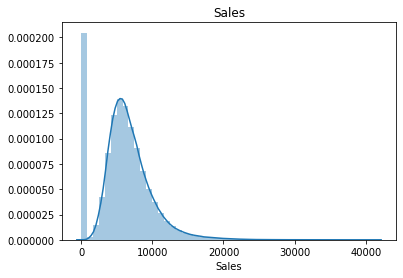

In [12]:
sns.distplot(df['Sales']).set_title('Sales')

# Distribution of Input Variables

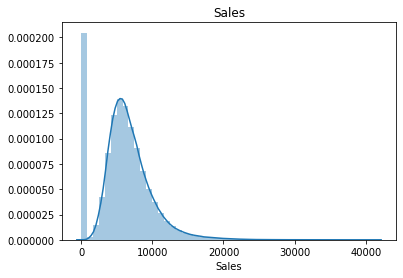

In [13]:
plt.figure();
sns.distplot(df['Sales']).set_title('Sales');

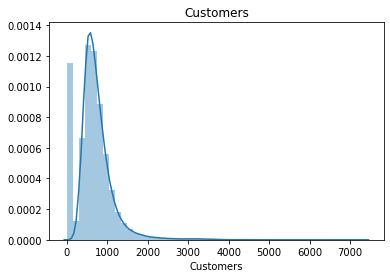

In [14]:
plt.figure();
sns.distplot(df['Customers']).set_title('Customers');

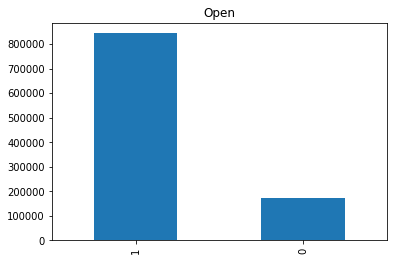

In [15]:
df['Open'].value_counts().plot(kind='bar',title='Open')

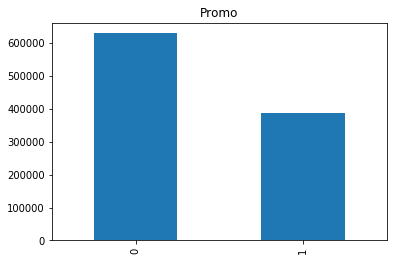

In [16]:
df['Promo'].value_counts().plot(kind='bar',title='Promo')

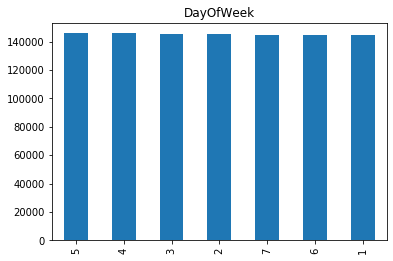

In [17]:
df['DayOfWeek'].value_counts().plot(kind='bar',title='DayOfWeek')

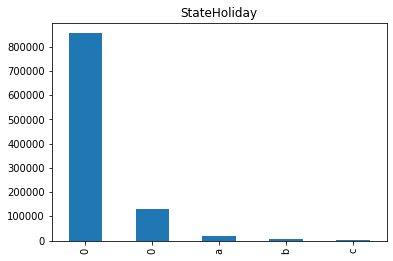

In [18]:
df['StateHoliday'].value_counts().plot(kind='bar',title='StateHoliday')

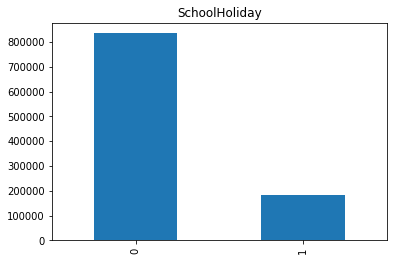

In [19]:
df['SchoolHoliday'].value_counts().plot(kind='bar',title='SchoolHoliday')

# Correlation Heatmap

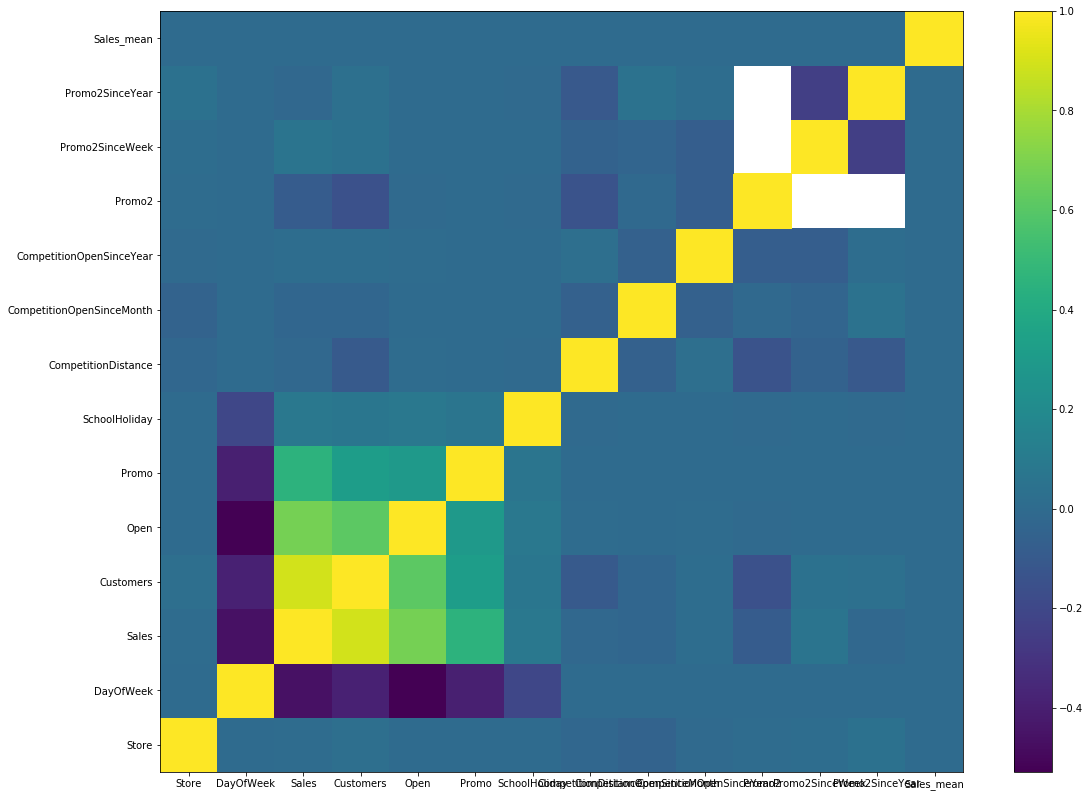

In [20]:
fig = plt.figure(figsize=(18,14))
corr = df.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5,len(corr.index),1),corr.index)
plt.xticks(np.arange(0.5,len(corr.columns),1),corr.columns)
fig.colorbar(c)

# Pair Plots

invalid value encountered in greater_equal
invalid value encountered in less_equal


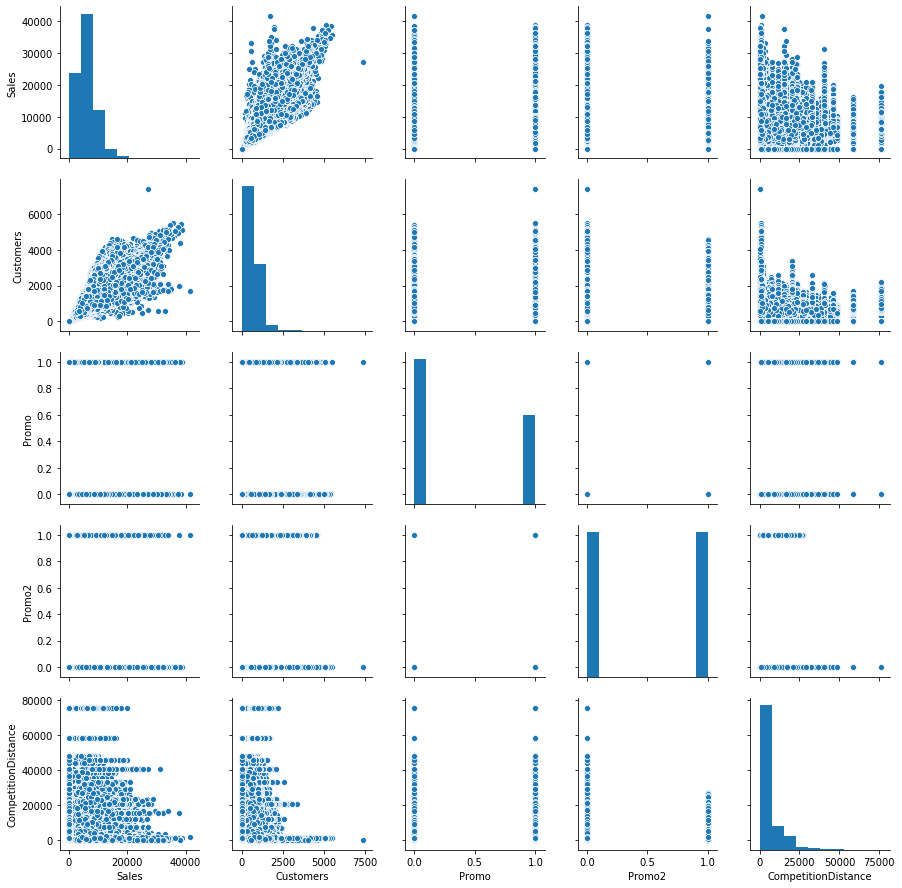

In [21]:
sns.pairplot(df,vars=['Sales', 'Customers', 'Promo','Promo2','CompetitionDistance'])

# Data Manipulation

In [22]:
# create "Month" variable to maybe find out some seasonality
df['Month'] = pd.to_datetime(df['Date']).dt.month

In [23]:
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales_mean,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,5773.818972,7
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,5773.818972,7
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,5773.818972,7
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,5773.818972,7
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,5773.818972,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,5773.818972,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,5773.818972,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,5773.818972,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,5773.818972,1


# Model Training

In [24]:
df = df.fillna(0)

In [25]:
df['StateHoliday_a'] = np.where(df['StateHoliday'] == 'a', 1, 0)
df['StateHoliday_b'] = np.where(df['StateHoliday'] == 'b', 1, 0)
df['StateHoliday_c'] = np.where(df['StateHoliday'] == 'c', 1, 0)
df['NotHoliday'] = np.where(df['StateHoliday'] == 0, 1, 0)
df['NotHoliday'] = np.where(df['StateHoliday'] == '0', 1, 0)

df_X, df_Y = df[['Store', 'CompetitionDistance', 'DayOfWeek', 
                 'Customers', 'Open', 'Promo', 'Promo2', 'StateHoliday_a', 'StateHoliday_b', 
                 'StateHoliday_c', 'NotHoliday', 'SchoolHoliday']], df['Sales'].values

In [26]:
df.shape

(1017209, 23)

In [27]:
df_test = pd.DataFrame(df.iloc[:250000,:])
df_train = pd.DataFrame(df.iloc[250000:,:])
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales_mean,Month,StateHoliday_a,StateHoliday_b,StateHoliday_c,NotHoliday
250000,634,3,2014-12-17,12675,968,1,1,0,0,d,...,0.0,0,0.0,0.0,5773.818972,12,0,0,0,1
250001,635,3,2014-12-17,10287,812,1,1,0,0,a,...,2014.0,0,0.0,0.0,5773.818972,12,0,0,0,1
250002,639,3,2014-12-17,7575,664,1,1,0,0,a,...,2006.0,0,0.0,0.0,5773.818972,12,0,0,0,1
250003,640,3,2014-12-17,17291,1148,1,1,0,0,d,...,0.0,0,0.0,0.0,5773.818972,12,0,0,0,1
250004,641,3,2014-12-17,8932,655,1,1,0,0,a,...,2003.0,1,36.0,2013.0,5773.818972,12,0,0,0,1


In [28]:
df_train_X, df_train_Y = df_train[['Store', 'CompetitionDistance', 'DayOfWeek', 
              'Customers', 'Open', 'Promo', 'Promo2', 'StateHoliday_a', 'StateHoliday_b',
              'StateHoliday_c', 'NotHoliday', 'SchoolHoliday']], df_train['Sales'].values

In [29]:
df_test_X, df_test_Y = df_test[['Store', 'CompetitionDistance', 'DayOfWeek', 
              'Customers', 'Open', 'Promo', 'Promo2', 'StateHoliday_a', 'StateHoliday_b',
              'StateHoliday_c', 'NotHoliday', 'SchoolHoliday']], df_test['Sales'].values

In [30]:
df['Sales_naive'] = df['Sales'].mean()

In [31]:
from sklearn.linear_model import LinearRegression
mod_lin = LinearRegression().fit(df_train_X,df_train_Y)
df_train['Sales_lin'] = mod_lin.predict(df_train_X)

In [32]:
df_test['Sales_lin'] = mod_lin.predict(df_test_X)

In [33]:
mod_lgbm = lightgbm.LGBMRegressor(max_depth=4,num_leaves=12,learing_rate=0.1)
mod_lgbm.fit(df_train_X, df_train_Y)
df_train['Sales_lgbm']=mod_lgbm.predict(df_train_X)

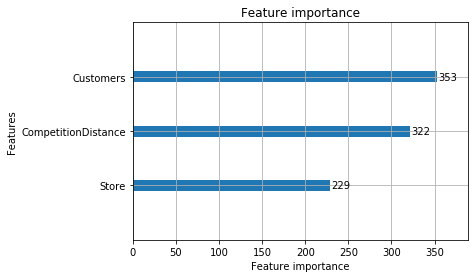

In [34]:
import lightgbm as lgb
lgb.plot_importance(mod_lgbm, max_num_features=3)

In [35]:
df_test['Sales_lgbm']=mod_lgbm.predict(df_test_X)

# Model Evaluation

In [36]:
print('naive mean',mean_squared_error(df['Sales'],df['Sales_naive']))
print('Linear regression',mean_squared_error(df_train['Sales'],df_train['Sales_lin']))
print('Linear regression test',mean_squared_error(df_test['Sales'],df_test['Sales_lin']))
print('gbm',mean_squared_error(df_train['Sales'],df_train['Sales_lgbm']))
print('gbm test',mean_squared_error(df_test['Sales'],df_test['Sales_lgbm']))

naive mean 14821916.983581567
Linear regression 2058955.81282211
Linear regression test 2297954.178024457
gbm 1177226.1237033117
gbm test 1372249.2997472407


# Panel

In [37]:
#convert year to datetime
df2 = df_train
df2['Store'] = pd.Categorical(df2['Store'])
df2['Date'] = pd.to_datetime(df2['Date'])
# #add column year to index
df2.set_index(['Store', 'Date'], inplace=True)
df2 = df2.sort_index()
df2

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Store Date                                                                
1     2013-01-01          2      0          0     0      0            a   
      2013-01-02          3   5530        668     1      0            0   
      2013-01-03          4   4327        578     1      0            0   
      2013-01-04          5   4486        619     1      0            0   
      2013-01-05          6   4997        635     1      0            0   
...                     ...    ...        ...   ...    ...          ...   
1115  2014-12-13          6   7880        525     1      0            0   
      2014-12-14          7      0          0     0      0            0   
      2014-12-15          1  12491        723     1      1            0   
      2014-12-16          2  11238        631     1      1            0   
      2014-12-17          3   9269        553     1      1            0   

                  SchoolHoliday StoreType Assortment  CompetitionDistance  \
Store Date                                                                  
1     2013-01-01              1         c          a               1270.0   
      2013-01-02              1         c          a               1270.0   
      2013-01-03              1         c          a               1270.0   
      2013-01-04              1         c          a               1270.0   
      2013-01-05              1         c          a               1270.0   
...                         ...       ...        ...                  ...   
1115  2014-12-13              0         d          c               5350.0   
      2014-12-14              0         d          c               5350.0   
      2014-12-15              0         d          c               5350.0   
      2014-12-16              0         d          c               5350.0   
      2014-12-17              0         d          c               5350.0   

                  ...  Promo2SinceWeek  Promo2SinceYear   Sales_mean  Month  \
Store Date        ...                                                         
1     2013-01-01  ...              0.0              0.0  5773.818972      1   
      2013-01-02  ...              0.0              0.0  5773.818972      1   
      2013-01-03  ...              0.0              0.0  5773.818972      1   
      2013-01-04  ...              0.0              0.0  5773.818972      1   
      2013-01-05  ...              0.0              0.0  5773.818972      1   
...               ...              ...              ...          ...    ...   
1115  2014-12-13  ...             22.0           2012.0  5773.818972     12   
      2014-12-14  ...             22.0           2012.0  5773.818972     12   
      2014-12-15  ...             22.0           2012.0  5773.818972     12   
      2014-12-16  ...             22.0           2012.0  5773.818972     12   
      2014-12-17  ...             22.0           2012.0  5773.818972     12   

                  StateHoliday_a  StateHoliday_b  StateHoliday_c  NotHoliday  \
Store Date                                                                     
1     2013-01-01               1               0               0           0   
      2013-01-02               0               0               0           1   
      2013-01-03               0               0               0           1   
      2013-01-04               0               0               0           1   
      2013-01-05               0               0               0           1   
...                          ...             ...             ...         ...   
1115  2014-12-13               0               0               0           1   
      2014-12-14               0               0               0           1   
      2014-12-15               0               0               0           1   
      2014-12-16               0               0               0           1   
      2014-12-17               0               0    

In [38]:
#convert year to datetime
df3 = df_test
df3['Store'] = pd.Categorical(df3['Store'])
df3['Date'] = pd.to_datetime(df3['Date'])
# #add column year to index
df3.set_index(['Store', 'Date'], inplace=True)
df3 = df3.sort_index()
df3

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Store Date                                                                
1     2014-12-17          3   7523        791     1      1            0   
      2014-12-18          4   7785        841     1      1            0   
      2014-12-19          5   7558        884     1      1            0   
      2014-12-20          6   8367        962     1      0            0   
      2014-12-21          7      0          0     0      0            0   
...                     ...    ...        ...   ...    ...          ...   
1115  2015-07-27          1  10712        608     1      1            0   
      2015-07-28          2   8093        500     1      1            0   
      2015-07-29          3   7661        473     1      1            0   
      2015-07-30          4   8405        502     1      1            0   
      2015-07-31          5   8680        538     1      1            0   

                  SchoolHoliday StoreType Assortment  CompetitionDistance  \
Store Date                                                                  
1     2014-12-17              0         c          a               1270.0   
      2014-12-18              0         c          a               1270.0   
      2014-12-19              0         c          a               1270.0   
      2014-12-20              0         c          a               1270.0   
      2014-12-21              0         c          a               1270.0   
...                         ...       ...        ...                  ...   
1115  2015-07-27              1         d          c               5350.0   
      2015-07-28              1         d          c               5350.0   
      2015-07-29              1         d          c               5350.0   
      2015-07-30              1         d          c               5350.0   
      2015-07-31              1         d          c               5350.0   

                  ...  Promo2SinceWeek  Promo2SinceYear   Sales_mean  Month  \
Store Date        ...                                                         
1     2014-12-17  ...              0.0              0.0  5773.818972     12   
      2014-12-18  ...              0.0              0.0  5773.818972     12   
      2014-12-19  ...              0.0              0.0  5773.818972     12   
      2014-12-20  ...              0.0              0.0  5773.818972     12   
      2014-12-21  ...              0.0              0.0  5773.818972     12   
...               ...              ...              ...          ...    ...   
1115  2015-07-27  ...             22.0           2012.0  5773.818972      7   
      2015-07-28  ...             22.0           2012.0  5773.818972      7   
      2015-07-29  ...             22.0           2012.0  5773.818972      7   
      2015-07-30  ...             22.0           2012.0  5773.818972      7   
      2015-07-31  ...             22.0           2012.0  5773.818972      7   

                  StateHoliday_a  StateHoliday_b  StateHoliday_c  NotHoliday  \
Store Date                                                                     
1     2014-12-17               0               0               0           1   
      2014-12-18               0               0               0           1   
      2014-12-19               0               0               0           1   
      2014-12-20               0               0               0           1   
      2014-12-21               0               0               0           1   
...                          ...             ...             ...         ...   
1115  2015-07-27               0               0               0           1   
      2015-07-28               0               0               0           1   
      2015-07-29               0               0               0           1   
      2015-07-30               0               0               0           1   
      2015-07-31               0               0    

In [52]:
from linearmodels.panel import PooledOLS
import statsmodels.api as sm
exog_vars = ['CompetitionDistance', 'DayOfWeek', 
                 'Customers', 'Open', 'Promo', 'Promo2', 'StateHoliday_a',
             'StateHoliday_b', 'StateHoliday_c', 'NotHoliday', 'SchoolHoliday']
exog = sm.add_constant(df2[exog_vars])
mod = PooledOLS(df2['Sales'], exog)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  Sales   R-squared:                        0.8591
Estimator:                  PooledOLS   R-squared (Between):              0.7010
No. Observations:              767209   R-squared (Within):               0.9220
Date:                Thu, Aug 06 2020   R-squared (Overall):              0.8591
Time:                        22:43:51   Log-likelihood                -6.666e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   4.253e+05
Entities:                        1115   P-value                           0.0000
Avg Obs:                       688.08   Distribution:               F(11,767197)
Min Obs:                       546.00                                           
Max Obs:                       716.00   F-statistic (robust):          4.253e+05
                            

In [40]:
df2['Sales_pooled']=pooled_res.predict(exog)
print('pooled',mean_squared_error(df2['Sales'],df2['Sales_pooled']))

pooled 2060809.3285662262


In [41]:
df3['Sales_pooled']=pooled_res.predict(sm.add_constant(df3[exog_vars]))
print('pooled test',mean_squared_error(df3['Sales'],df3['Sales_pooled']))

pooled test 2300530.457082276


Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


In [51]:
from linearmodels.panel import PanelOLS
mod = PanelOLS(df2['Sales'], exog)
panel_res = mod.fit()
print(panel_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  Sales   R-squared:                        0.8591
Estimator:                   PanelOLS   R-squared (Between):              0.7010
No. Observations:              767209   R-squared (Within):               0.9220
Date:                Thu, Aug 06 2020   R-squared (Overall):              0.8591
Time:                        22:43:41   Log-likelihood                -6.666e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   4.253e+05
Entities:                        1115   P-value                           0.0000
Avg Obs:                       688.08   Distribution:               F(11,767197)
Min Obs:                       546.00                                           
Max Obs:                       716.00   F-statistic (robust):          4.253e+05
                            

In [43]:
df2['Sales_panel']=panel_res.predict(exog)
print('panel',mean_squared_error(df2['Sales'],df2['Sales_panel']))

panel 2060809.3285662262


In [44]:
df3['Sales_panel']=panel_res.predict(sm.add_constant(df3[exog_vars]))
print('panel test',mean_squared_error(df3['Sales'],df3['Sales_panel']))

panel test 2300530.457082276


Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


In [45]:
from linearmodels.panel import RandomEffects
mod = RandomEffects(df2['Sales'], exog)
rand_res = mod.fit()
print(rand_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Sales   R-squared:                        0.9344
Estimator:              RandomEffects   R-squared (Between):              0.5516
No. Observations:              767209   R-squared (Within):               0.9346
Date:                Thu, Aug 06 2020   R-squared (Overall):              0.8240
Time:                        22:38:51   Log-likelihood                -6.241e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   9.939e+05
Entities:                        1115   P-value                           0.0000
Avg Obs:                       688.08   Distribution:               F(11,767197)
Min Obs:                       546.00                                           
Max Obs:                       716.00   F-statistic (robust):          9.939e+05
                            

In [46]:
df2['Sales_rand']=rand_res.predict(exog)
print('rand',mean_squared_error(df2['Sales'],df2['Sales_rand']))

rand 2575251.191905991


In [47]:
df3['Sales_rand']=rand_res.predict(sm.add_constant(df3[exog_vars]))
print('rand test',mean_squared_error(df3['Sales'],df3['Sales_rand']))

rand test 2740712.9798820545


Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
